# **Example of Integrating a Network**

## Creating a Network

We will start by looking at the CNO network for simplicity. We will first need to import pynucastro, read through the ReacLib library, and pass in the names of the reaction rates we are interested in. 

In [1]:
import pynucastro as pyna
rl = pyna.ReacLibLibrary()
rate_names = ["c12(p,g)n13",
              "c13(p,g)n14",
              "n13(,)c13",
              "n13(p,g)o14",
              "n15(p,a)c12",
              "o14(,)n14",
              "o15(,)n15"]

rates = rl.get_rate_by_name(rate_names)
rates

[C12 + p ⟶ N13 + 𝛾,
 C13 + p ⟶ N14 + 𝛾,
 N13 ⟶ C13 + e⁺ + 𝜈,
 N13 + p ⟶ O14 + 𝛾,
 N15 + p ⟶ He4 + C12,
 O14 ⟶ N14 + e⁺ + 𝜈,
 O15 ⟶ N15 + e⁺ + 𝜈]

<font color= blue>PythonNetwork</font> has methods to write thhe RHS of the system of ODEs.

In [2]:
pynet = pyna.PythonNetwork(rates=rates)

The <font color= blue>write_network()</font> method outputs the Python code that is used to define the RHS for integration to a file you choose.

In [3]:
pynet.write_network("cno_test_integrate.py")

## Integrating a Network

There are a wide variety of ODE integration solvers within the Julia DifferentialEquation package. They can be located at the [DifferentialEquation.jl docs](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/) along with other useful information about the package. 

In [4]:
import numba
import numpy as np
from diffeqpy import de
import cno_test_integrate as cno #importing network created

After importing all the necessary libraries and modules, we can intialize the thermodynamic conditions, intial compositions, the time span, and the algorithm or method we will be using to solve with.

In [5]:
rho = 150. #g/cm^3
T = 1.5e7  #K
screen_func = None

Y0 = np.zeros((cno.nnuc), dtype=np.float64) #Intialize array of mass fractions

Y0[cno.jp] = 0.7 #Solar mix of mass fractions
Y0[cno.jhe4] = 0.28
Y0[cno.jc12] = 0.02

Y0[:] = Y0[:]/cno.A[:] #Converting to molar fractions

tspan = (0.0, 1.e6) 
p = np.array([rho, T]) #Array of initial parameters
alg = de.FBDF() #Choosing integration method

We can then write the functions to return the jacobian and the RHS of the Differential Equations. Numba can be used to do just-in-time compilation of the functions to speed up the code. 

In [6]:
def f(u, p, t): #u = array of unknowns, p = array of parameters, t = array of time
   rho, T = p
   Y = u
   return cno.rhs_eq(t, Y, rho, T, None) #calling RHS 

def f_jac(u, p, t):
   rho, T = p
   Y = u
   return cno.jacobian_eq(t, Y, rho, T, None) #Calling Jacobian

numba_f = numba.njit(f) #Using Numba on functions
numba_jac = numba.njit(f_jac)

ff = de.ODEFunction(numba_f, jac=numba_jac)

We combine the function <font color= blue>f(u, p, t)</font> and <font color= blue>f_jac(u, p, t)</font> into a single variable <font color= blue>ff</font>. The reason for this is because the first parameter in <font color= blue>de.ODEProblem()</font> must be a single variable calling the functions.

In [7]:
prob = de.ODEProblem(ff, Y0, tspan, p)
sol = de.solve(prob, alg, saveat=.1, abstol=1.e-9, reltol=1.e-9)

For more information on ODE Problems visit [DifferentialEquation.jl docs](https://docs.sciml.ai/DiffEqDocs/stable/types/ode_types/)

# Printing and Plotting

It is useful to be able to print and plot certain things to gain a better understanding of what is going on with the solver method and the reactions. Below are useful print statements to help you understand what is going on behind the scenes.

In [8]:
print(sol.retcode) #Tells you if it successfully solved 

<PyCall.jlwrap Success>


In [9]:
print(sol.stats) #Gives statistics on what the solver did

<PyCall.jlwrap DiffEqBase.Stats
Number of function 1 evaluations:                  14
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    4
Number of linear solves:                           7
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             7
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          4
Number of rejected steps:                          0>


In [10]:
print("Final Y =", sol.u[-1]) #prints out final molar fractions

Final Y = [7.00000000e-01 7.00000000e-02 1.66666660e-03 6.27523616e-11
 5.41841859e-14 7.42311631e-18 0.00000000e+00 1.49749056e-27
 0.00000000e+00]


## *I believe this plot works but could be more efficient and condensed*

In [11]:
spec_1 = []
spec_2 = []
spec_3 = []
spec_4 = []
spec_5 = []
spec_6 = []
spec_7 = []
spec_8 = []
spec_9 = []
for list in sol.u:
    spec_1.append(list[0])
    spec_2.append(list[1])
    spec_3.append(list[2])
    spec_4.append(list[3])
    spec_5.append(list[4])
    spec_6.append(list[5])
    spec_7.append(list[6])
    spec_8.append(list[7])
    spec_9.append(list[8])
        

In [12]:
species = [spec_1, spec_2, spec_3, spec_4, spec_5, spec_6, spec_7, spec_8, spec_9] 

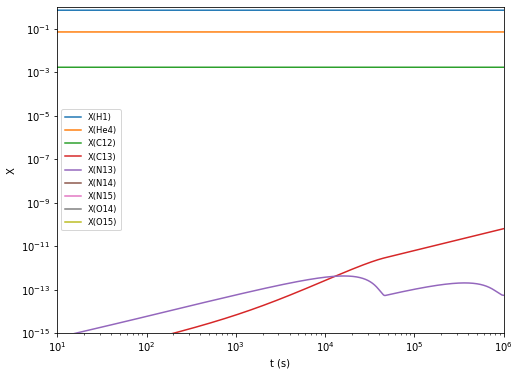

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(cno.nnuc):
    ax.loglog(sol.t, species[i], label=f"X({cno.names[i].capitalize()})")

ax.set_xlim(1.e1, 1.e6)
ax.set_ylim(1.e-15, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))